# Прогнозирование оттока клиентов для оператора связи «ТелеДом»

## Описание проекта
Цель данного проекта — разработать модель машинного обучения для предсказания оттока клиентов у оператора связи «ТелеДом». На основе имеющихся данных о клиентах и их услугах модель будет прогнозировать вероятность того, что клиент разорвёт договор. Это позволит компании предложить промокоды и специальные условия клиентам, которые с высокой вероятностью могут отказаться от услуг связи, что поможет сократить отток клиентов и повысить удержание.

## Содержание проекта

### 1. Загрузка данных
- Загрузка данных из предоставленных файлов:
  - `contract_new.csv` — информация о договоре
  - `personal_new.csv` — персональные данные клиента
  - `internet_new.csv` — информация об интернет-услугах
  - `phone_new.csv` — информация об услугах телефонии
- Первичный осмотр данных (проверка структуры, типов данных, наличия пропусков).

### 2. Исследовательский анализ и предобработка данных
- Выполнение исследовательского анализа каждого датафрейма:
  - Описание данных и их статистики
  - Выявление пропусков и аномалий
  - Определение релевантности признаков для модели
- Предобработка данных:
  - Обработка пропусков
  - Обработка неявных дубликатов
  - Преобразование типов данных

### 3. Объединение данных
- Объединение данных из различных файлов по ключу `customerID`.
- Создание единого датафрейма, включающего все необходимые признаки для анализа.

### 4. Исследовательский анализ и предобработка объединённого датафрейма
- Проведение анализа объединённого датафрейма:
  - Визуализация распределений признаков
  - Корреляционный анализ
  - Выявление потенциально важных признаков
- Генерация новых признаков, если это уместно.

### 5. Подготовка данных
- Подготовка данных для обучения моделей:
  - Разделение данных на тренировочную и тестовую выборки
  - Применение масштабирования и кодирования признаков с учётом особенностей данных и моделей

### 6. Обучение моделей машинного обучения
- Обучение как минимум двух моделей для прогнозирования оттока клиентов:
  - Логистическая регрессия
  - Дерево решений / Случайный лес / Градиентный бустинг (выбрать в зависимости от требований)
- Подбор гиперпараметров для хотя бы одной модели с использованием методов перекрестной проверки.

### 7. Выбор лучшей модели
- Оценка качества моделей на тестовой выборке:
  - Метрики качества (точность, полнота, F1-score, ROC AUC и др.)
- Выбор наилучшей модели на основе её производительности и интерпретируемости.

### 8. Общий вывод и рекомендации заказчику
- Обзор проделанной работы и полученных результатов
- Рекомендации по применению модели для бизнеса:
  - Как использовать предсказания для улучшения удержания клиентов
  - Возможные шаги по дополнительному улучшению модели и процессам

## Описание данных

### Файл `contract_new.csv`
- `customerID` — идентификатор абонента
- `BeginDate` — дата начала действия договора
- `EndDate` — дата окончания действия договора
- `Type` — тип оплаты (раз в год-два или ежемесячно)
- `PaperlessBilling` — электронный расчётный лист (да/нет)
- `PaymentMethod` — тип платежа
- `MonthlyCharges` — расходы за месяц
- `TotalCharges` — общие расходы абонента

### Файл `personal_new.csv`
- `customerID` — идентификатор пользователя
- `gender` — пол
- `SeniorCitizen` — является ли абонент пенсионером (1/0)
- `Partner` — есть ли у абонента супруг или супруга (да/нет)
- `Dependents` — есть ли у абонента дети (да/нет)

### Файл `internet_new.csv`
- `customerID` — идентификатор пользователя
- `InternetService` — тип подключения (DSL/Fiber optic/None)
- `OnlineSecurity` — блокировка опасных сайтов (да/нет)
- `OnlineBackup` — облачное хранилище файлов (да/нет)
- `DeviceProtection` — антивирус (да/нет)
- `TechSupport` — выделенная линия технической поддержки (да/нет)
- `StreamingTV` — стриминговое телевидение (да/нет)
- `StreamingMovies` — каталог фильмов (да/нет)

### Файл `phone_new.csv`
- `customerID` — идентификатор пользователя
- `MultipleLines` — подключение телефона к нескольким линиям одновременно (да/нет)

# 1. Загрузка данных

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
)
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
import shap
from sklearn.dummy import DummyClassifier

In [3]:
RANDOM_STATE = 20924

In [4]:
try:
    contract = pd.read_csv('contract_new.csv')

except:
    contract = pd.read_csv('/datasets/contract_new.csv')

try:
    personal = pd.read_csv('personal_new.csv')

except:
    personal = pd.read_csv('/datasets/personal_new.csv')
    
try:
    internet = pd.read_csv('internet_new.csv')

except:
    internet = pd.read_csv('/datasets/internet_new.csv')
    
try:
    phone = pd.read_csv('phone_new.csv')

except:
    phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
def get_data_info(data):
    display(data.sample(5))
    print('-----'*20)
    display(data.info())
    print('-----'*20)
    display(data.describe(include='all'))

### contract_new.csv

In [6]:
get_data_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5608,9705-ZJBCG,2019-01-01,No,One year,No,Bank transfer (automatic),54.15,703.95
2210,7036-TYDEC,2014-05-01,No,Two year,No,Electronic check,104.00,7319.52
5275,9530-EHPOH,2018-11-01,No,Month-to-month,No,Electronic check,53.75,806.25
5066,7191-ADRGF,2016-06-01,No,Two year,No,Bank transfer (automatic),54.30,2389.2
4349,7903-CMPEY,2019-10-01,No,Month-to-month,Yes,Electronic check,80.30,321.2


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

----------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


### personal_new.csv

In [7]:
get_data_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
2002,0017-DINOC,Male,0,No,No
1191,8221-HVAYI,Male,0,Yes,Yes
5805,1697-NVVGY,Male,1,Yes,No
430,9063-ZGTUY,Female,0,Yes,Yes
5732,1580-BMCMR,Male,1,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

----------------------------------------------------------------------------------------------------


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


### internet_new.csv

In [8]:
get_data_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3033,2898-LSJGD,DSL,Yes,No,Yes,No,Yes,Yes
2677,8749-JMNKX,Fiber optic,Yes,No,Yes,No,Yes,No
4538,6754-LZUKA,DSL,No,Yes,Yes,No,Yes,Yes
3690,2192-CKRLV,DSL,Yes,Yes,Yes,No,No,Yes
3669,6008-NAIXK,DSL,No,Yes,Yes,No,Yes,Yes


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

----------------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### phone_new.csv

In [9]:
get_data_info(phone)

,customerID,MultipleLines
414,1480-BKXGA,Yes
1399,6326-MTTXK,Yes
5329,3410-MHHUM,Yes
6351,3605-JISKB,Yes
657,6786-OBWQR,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

----------------------------------------------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


На основе анализа предоставленных данных можно сделать следующие выводы:

#### Структура данных:

Данные представлены в нескольких таблицах, каждая из которых содержит информацию о клиентах. Таблицы связаны по уникальному идентификатору клиента (customerID).
Некоторые таблицы содержат меньше записей, что указывает на то, что не все клиенты пользуются всеми услугами (например, интернет или телефон).

#### Типы данных:

В большинстве столбцов встречаются категориальные данные (например, PaperlessBilling, PaymentMethod, InternetService, и т.д.), которые представлены в виде строковых значений.
Есть числовые столбцы, такие как MonthlyCharges (ежемесячные расходы) и TotalCharges (общие расходы), но столбец TotalCharges почему-то имеет тип данных object, что может потребовать дополнительной обработки (конвертация в числовой тип).
Много данных, где переменные принимают два значения (например, Yes/No, 0/1), что потребует перекодировки (One-Hot Encoding) для последующего использования в моделях машинного обучения.

#### Отсутствие пропусков и дубликатов:

Пропусков в данных нет, что является положительным моментом, и нет дубликатов в идентификаторах клиентов, что упрощает обработку данных.

#### Баланс классов:

Необходимо будет проанализировать распределение целевых классов (например, ушедшие клиенты и оставшиеся) на предмет дисбаланса, который может потребовать применения методов балансировки (например, апсемплинг).

#### Необходимость создания дополнительных признаков:

Важно создать целевой признак, который будет указывать на факт ухода клиента. Для этого можно использовать информацию о дате завершения контракта (EndDate).
Также необходимо создать признак, отражающий количество времени, в течение которого клиент пользуется услугами компании (разница между BeginDate и текущей датой или EndDate).

#### Избыточные признаки:

Некоторые признаки могут не иметь существенного влияния на предсказание ухода клиента. Например, пол клиента (gender) или способ оплаты (PaymentMethod) могут оказаться несущественными для анализа.

#### Рекомендации по обработке данных:

Требуется конвертация категориальных данных в числовые с помощью метода One-Hot Encoding.
Стоит провести исследование корреляции между признаками, чтобы исключить избыточные и малозначимые признаки.
Возможно потребуется балансировка классов для улучшения качества предсказательной модели.

# 2. Исследовательский анализ и предобработка данных

In [10]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [12]:
contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

In [13]:
contract.duplicated().sum()

0

In [14]:
contract[contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


In [15]:
contract = contract[~(contract['TotalCharges'].isnull())]
contract[contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [16]:
personal.duplicated().sum()

0

In [17]:
personal['SeniorCitizen'].unique()

array([0, 1])

In [18]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


In [19]:
internet.duplicated().sum()

0

In [20]:
phone.duplicated().sum()

0

На основе анализа данных можно сделать следующие выводы:

#### Отсутствие данных по столбцам:

Столбец EndDate имеет 5942 пропуска, что связано с тем, что это данные о действующих клиентах на 1 февраля 2020 года. Эти пропуски логичны, так как клиенты ещё не покинули компанию на момент актуализации данных.

В столбце TotalCharges обнаружено 11 пропусков. Это данные о недавно подключившихся клиентах, у которых ещё не накоплены расходы. Пропуски в этом столбце были удалены, чтобы избежать ошибок в дальнейшем анализе.

#### Дублирование данных:

В таблицах contract, personal, internet, и phone дублирующихся записей не обнаружено, что говорит о хорошей структуре данных.

#### Замена значений:

В столбце SeniorCitizen таблицы personal были заменены числовые значения (0 и 1) на текстовые (No и Yes), что упрощает интерпретацию данных.

#### Целевой признак:

В будущем целевой признак будет основан на столбце EndDate, где отсутствие значения будет означать, что клиент всё ещё остаётся в компании (признак 0), а наличие даты будет указывать на то, что клиент покинул компанию (признак 1).

# 3. Объединение данных

In [21]:
phone['Phone'] = 'Yes'

In [22]:
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')

In [23]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,Phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,...,No,NaN,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,...,No,No,Yes,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,...,No,No,Yes,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,...,No,NaN,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,...,No,No,Yes,Fiber optic,No,No,No,No,No,No


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   object        
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  MultipleLines     6352 non-null   object        
 13  Phone             6352 non-null   object        
 14  InternetService   5512 n

In [25]:
data[['MultipleLines', 'Phone', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender']] = data[['MultipleLines', 'Phone',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender']].fillna('No')

### Создание новых признаков

In [26]:
data['ContractBroken'] = data['EndDate'].apply(lambda x: 'Yes' if pd.notnull(x) else 'No')
data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,MultipleLines,Phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,ContractBroken
4087,8687-BAFGU,2020-01-01,NaT,Month-to-month,No,Electronic check,74.00,74.00,Male,No,...,No,Yes,Fiber optic,No,No,No,Yes,No,No,No
6582,5832-XKAES,2019-09-01,NaT,Month-to-month,Yes,Credit card (automatic),69.80,349.00,Male,No,...,No,Yes,Fiber optic,No,No,No,No,No,No,No
4942,6892-EZDTG,2019-09-01,NaT,Month-to-month,Yes,Electronic check,91.65,458.25,Female,No,...,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,No
4653,9415-ZNBSX,2014-04-01,2017-10-01,Two year,Yes,Bank transfer (automatic),89.00,4037.04,Female,No,...,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2860,3617-XLSGQ,2014-08-01,NaT,Two year,No,Bank transfer (automatic),109.25,7643.13,Female,No,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,No


In [27]:
data['TotalTime'] = data['EndDate'] - data['BeginDate']
data['TotalTime'] = data['TotalTime'].fillna(pd.to_datetime('2020-02-01') - data['BeginDate'])
data['TotalTime'] = data['TotalTime'].dt.days

In [28]:
data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,ContractBroken,TotalTime
10,9763-GRSKD,2019-01-01,NaT,Month-to-month,Yes,Mailed check,49.95,649.35,Male,No,...,Yes,DSL,Yes,No,No,No,No,No,No,396
3171,5044-XDPYX,2015-11-01,NaT,Two year,No,Mailed check,25.50,1339.52,Female,No,...,Yes,No,No,No,No,No,No,No,No,1553
4165,1905-OEILC,2020-01-01,NaT,Month-to-month,No,Mailed check,19.50,21.45,Female,No,...,Yes,No,No,No,No,No,No,No,No,31
6326,7798-JVXYM,2018-12-01,NaT,Month-to-month,Yes,Electronic check,69.65,975.10,Female,No,...,Yes,DSL,No,No,No,Yes,Yes,Yes,No,427
5357,8232-CTLKO,2014-08-01,NaT,Two year,Yes,Electronic check,59.75,4022.37,Female,No,...,Yes,DSL,Yes,No,No,No,Yes,No,No,2010


In [29]:
data['InterntOrPhone'] = 'Both'

data.loc[data['Phone'] == 'No', 'InterntOrPhone'] = 'Internet only'
data.loc[data['InternetService'] == 'No', 'InterntOrPhone'] = 'Phone only'

### Удаление иррелевантных признаков

In [30]:
data = data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   object 
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   MultipleLines     7032 non-null   object 
 10  Phone             7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null   object 


На основе проделанной работы с данными можно сделать следующие выводы:

#### Объединение данных:

Данные из таблиц contract, personal, phone, и internet были успешно объединены в одну общую таблицу. В процессе объединения возникли пропуски (NaN) в столбцах, связанных с использованием интернета и телефона, так как некоторые клиенты не использовали эти услуги. Эти пропуски были логично заменены значением 'No'.

#### Создание новых признаков:

Был создан целевой признак ContractBroken, который указывает, разорван ли контракт (если столбец EndDate не пустой).

Создан признак TotalTime, который рассчитывает количество дней, в течение которых клиент пользовался услугами. Для клиентов, чьи контракты ещё действуют, вместо даты окончания использована дата 1 февраля 2020 года.

Добавлен новый признак InterntOrPhone, который показывает, какими услугами пользовался клиент: только интернет (0), только телефон (1), или оба (2).

#### Очистка данных:

Были удалены нерелевантные признаки, такие как customerID, BeginDate, EndDate, и gender, так как они не требуются для дальнейшего анализа или построения модели.

#### Структура данных:

Итоговая таблица содержит 7032 записи и 20 признаков, которые представляют собой полную информацию о клиентах, включая их тип договора, методы оплаты, услуги (интернет и телефон), а также временные характеристики (длительность обслуживания).


# 4. Исследовательский анализ и предобработка объединённого датафрейма

### Нахождение аномальных значений 

In [31]:
for col in data.select_dtypes(include=['object']):
    print('The list of unique values for', col, ':', data[col].sort_values().unique())

The list of unique values for Type : ['Month-to-month' 'One year' 'Two year']
The list of unique values for PaperlessBilling : ['No' 'Yes']
The list of unique values for PaymentMethod : ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
The list of unique values for gender : ['Female' 'Male']
The list of unique values for SeniorCitizen : ['No' 'Yes']
The list of unique values for Partner : ['No' 'Yes']
The list of unique values for Dependents : ['No' 'Yes']
The list of unique values for MultipleLines : ['No' 'Yes']
The list of unique values for Phone : ['No' 'Yes']
The list of unique values for InternetService : ['DSL' 'Fiber optic' 'No']
The list of unique values for OnlineSecurity : ['No' 'Yes']
The list of unique values for OnlineBackup : ['No' 'Yes']
The list of unique values for DeviceProtection : ['No' 'Yes']
The list of unique values for TechSupport : ['No' 'Yes']
The list of unique values for StreamingTV : ['No' 'Yes']
The list of unique 

Basic statistical parameters for: MonthlyCharges
count    7032.00
mean       64.80
std        30.09
min        18.25
25%        35.59
50%        70.35
75%        89.86
max       118.75
Name: MonthlyCharges, dtype: float64

Boxplot and a histogram of the distribution of values for: MonthlyCharges


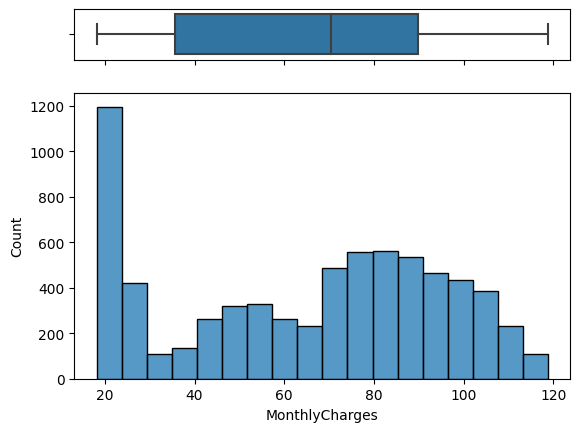

----------------------------------------------------------------------------------------------------
Basic statistical parameters for: TotalCharges
count    7032.00
mean     2118.62
std      2112.74
min        19.05
25%       439.74
50%      1345.28
75%      3239.32
max      9221.38
Name: TotalCharges, dtype: float64

Boxplot and a histogram of the distribution of values for: TotalCharges


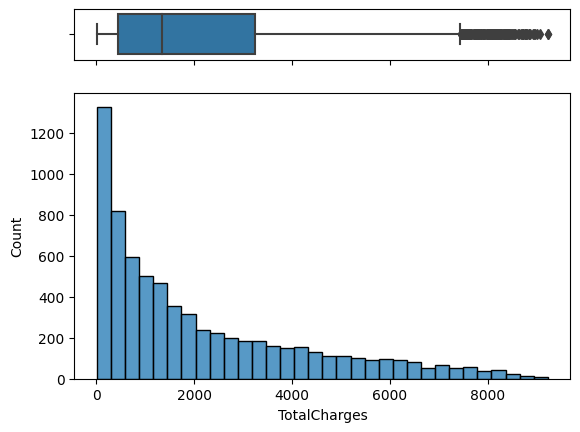

----------------------------------------------------------------------------------------------------
Basic statistical parameters for: TotalTime
count    7032.00
mean      899.96
std       682.74
min        28.00
25%       276.00
50%       761.00
75%      1461.00
max      2314.00
Name: TotalTime, dtype: float64

Boxplot and a histogram of the distribution of values for: TotalTime


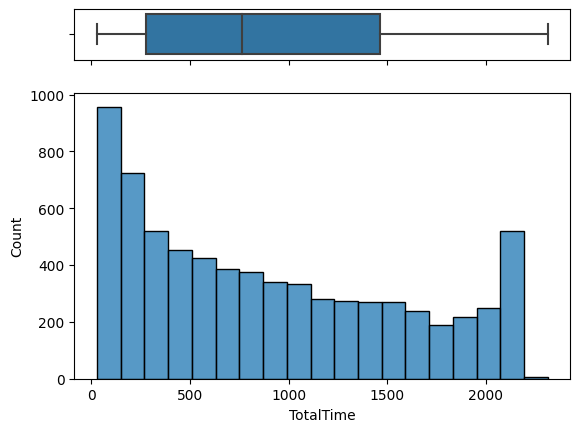

----------------------------------------------------------------------------------------------------


In [32]:
numerical_features = ['MonthlyCharges', 'TotalCharges', 'TotalTime']

for i in data[numerical_features]:
    print('Basic statistical parameters for:', i)
    print((data[i].describe().round(2)))
    print()
    print('Boxplot and a histogram of the distribution of values for:', i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data[i], ax=ax_box)
    sns.histplot(data=data, x=i, ax=ax_hist)
    ax_box.set(xlabel='')
    plt.show()
    print('-----'*20)

Distribution of classes of a categorical variable: Type


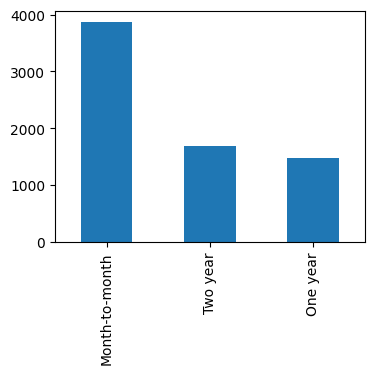

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: PaperlessBilling


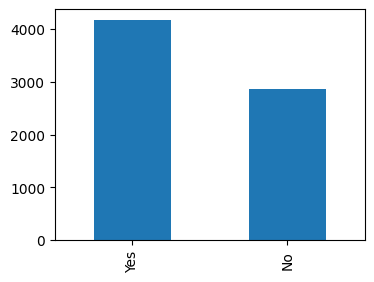

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: PaymentMethod


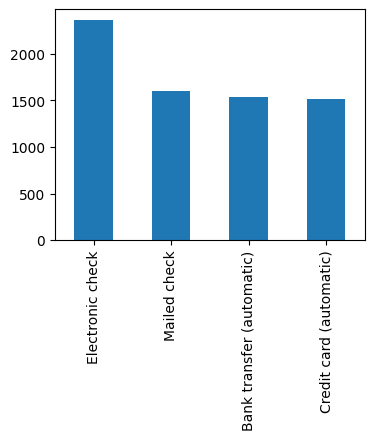

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: SeniorCitizen


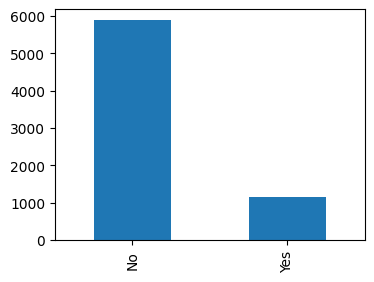

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: Partner


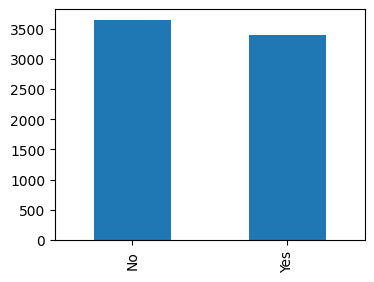

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: Dependents


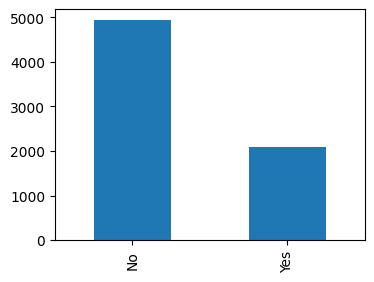

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: MultipleLines


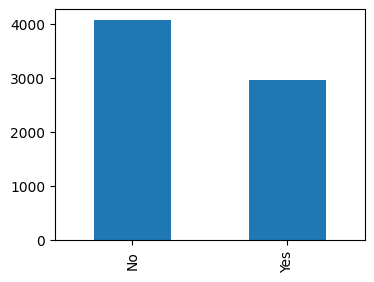

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: Phone


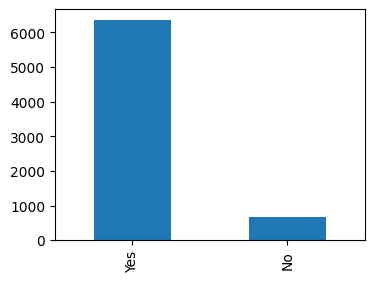

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: InternetService


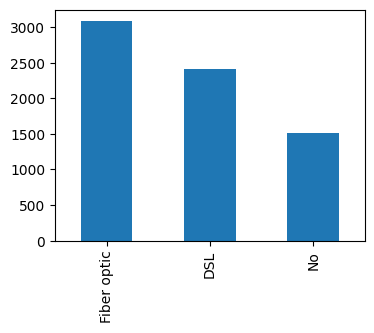

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: OnlineSecurity


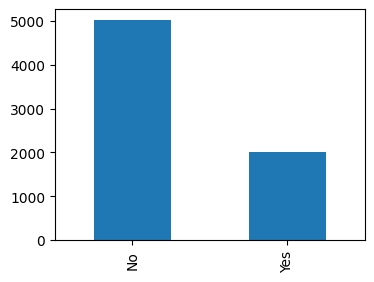

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: OnlineBackup


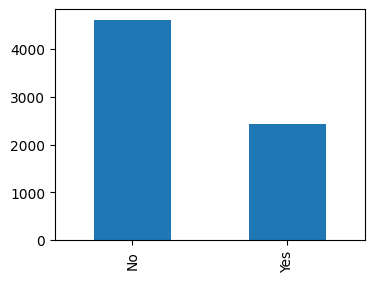

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: DeviceProtection


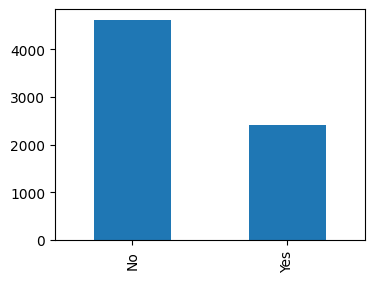

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: TechSupport


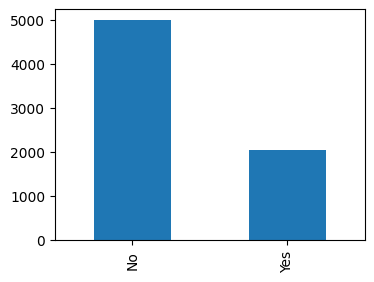

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: StreamingTV


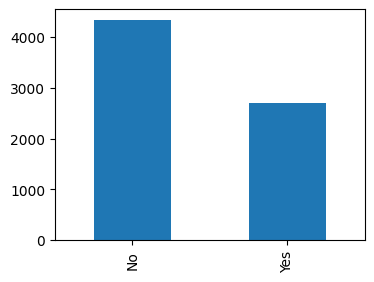

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: StreamingMovies


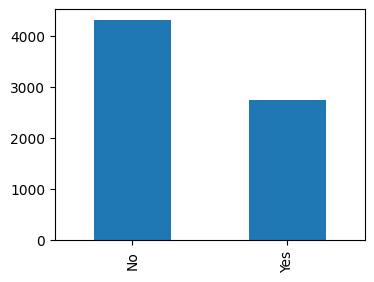

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: ContractBroken


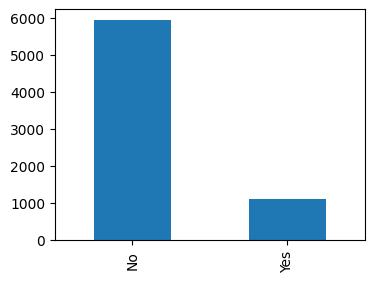

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: InterntOrPhone


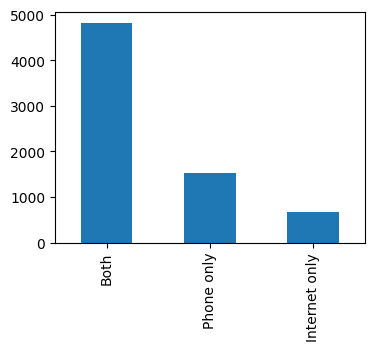

----------------------------------------------------------------------------------------------------
Distribution of classes of a categorical variable: gender


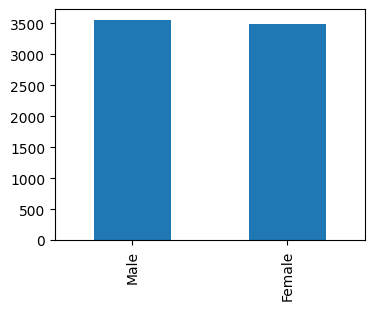

----------------------------------------------------------------------------------------------------


In [33]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod',
       'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'Phone', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'ContractBroken', 'InterntOrPhone', 'gender']

for i in data[categorical_features]:
    print('Distribution of classes of a categorical variable:', i)
    data[i].value_counts().plot(kind='bar', figsize=(4,3))
    plt.show()
    print('-----'*20)

На основе проведённого анализа данных можно сделать следующие выводы:

#### Анализ категориальных признаков:

* Данные показывают, что клиенты, подписанные на помесячные контракты, составляют большинство (55%). Этот факт может свидетельствовать о высоком уровне гибкости, который предпочитают клиенты, но также может указывать на высокую текучесть. Оценка причин расторжения контрактов может помочь в разработке стратегий для удержания клиентов.
* Классы пользователей с долгосрочными контрактами (например, "Two year") составляют меньшую часть по сравнению с помесячными контрактами. Это может указывать на потенциальные возможности для внедрения программ лояльности или предложений, которые стимулируют клиентов к более длительным контрактам.
* Количество пенсионеров значительно меньше по сравнению с остальными клиентами (примерно в 6 раз меньше), что может быть связано с их меньшей потребностью в данных услугах.
* Почти равное распределение наблюдается среди клиентов с партнёром и без него, что может свидетельствовать о том, что наличие партнёра не оказывает значительного влияния на выбор данных услуг.
* Среди клиентов есть значительный дисбаланс в разрыве контрактов: пользователи, которые расторгли контракт, составляют значительно меньшую долю, что говорит о высокой степени удержания клиентов.
* Большинство клиентов используют как телефонные, так и интернет-услуги. Это подтверждает, что предложения пакетов услуг могут быть более привлекательными и привести к увеличению числа подписчиков на оба типа услуг.

#### Анализ числовых признаков:

* Средние и медианные значения месячных расходов клиентов близки к 64.80 и 70.35 соответственно, что свидетельствует о том, что большинство пользователей склонны выбирать умеренные по стоимости тарифные планы.
* Минимальное значение общих расходов клиентов составляет 19.05, что, скорее всего, связано с новыми клиентами или пользователями, которые быстро расторгли контракт.
* Количество дней в статусе клиента распределено равномерно, однако можно выделить значения около 100 дней и более 2000 дней, что отражает различные жизненные циклы клиентов.

#### Тенденции и закономерности:

* Большинство клиентов предпочитают электронные платежи (например, электронные чеки), что отражает тренд к цифровизации финансовых услуг.
* Пенсионеров и клиентов с зависимыми членами семьи существенно меньше, что может говорить о том, что данные категории людей реже нуждаются в подключении подобных услуг.
* Услуги по безопасности (например, OnlineSecurity, TechSupport) менее популярны среди клиентов, чем базовые услуги, такие как телефон и интернет, что может свидетельствовать о недостаточной осведомлённости о таких услугах или об их низкой воспринимаемой ценности.

### Корреляционный анализ

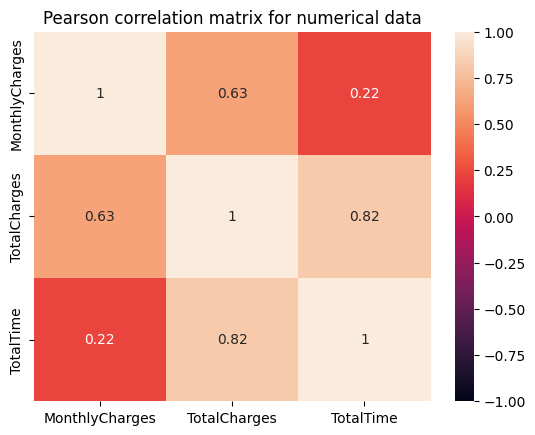

In [34]:
sns.heatmap(data[numerical_features].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Pearson correlation matrix for numerical data')
plt.show()

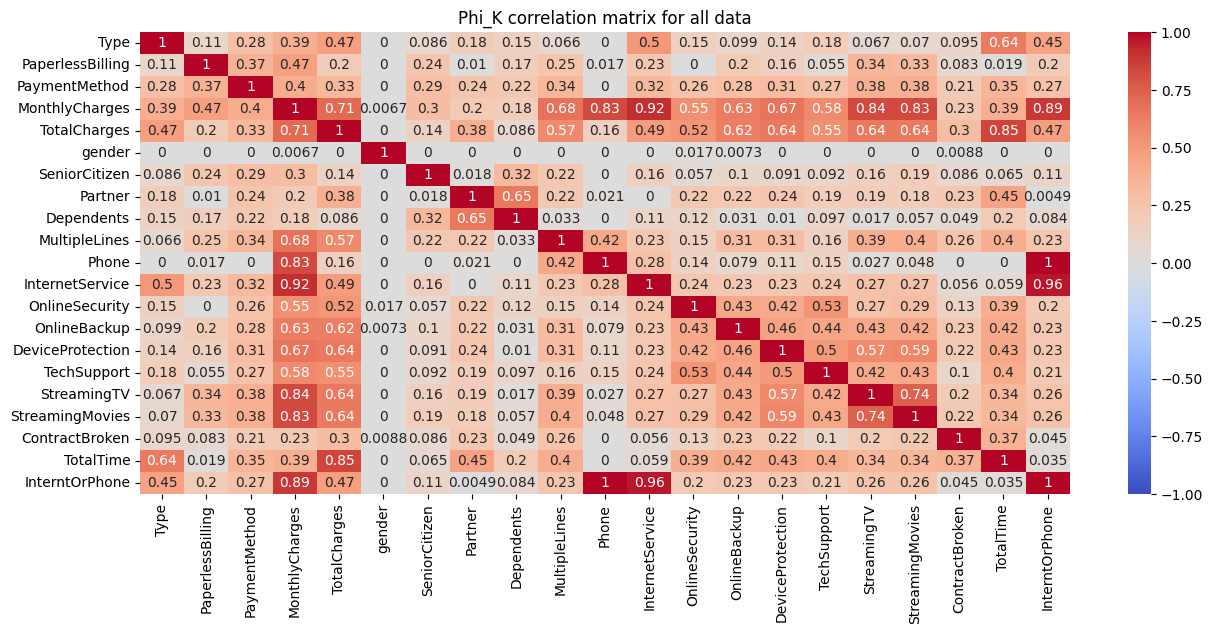

In [35]:
cols = ['MonthlyCharges', 'TotalCharges', 'TotalTime']
plt.figure(figsize=(15, 6))
sns.heatmap(data.phik_matrix(interval_cols=cols), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', annot=True)
plt.title('Phi_K correlation matrix for all data')
plt.show()

В данном случае, признак `gender` (пол) может быть удален из анализа по следующим причинам:

1. Отсутствие корреляции: Согласно матрице корреляции Phi, признак gender практически не коррелирует с другими признаками в данных. Его значения по отношению к другим переменным равны нулю или очень близки к нему, что указывает на отсутствие значимых связей с другими переменными.

2. Малое влияние на модель: С учетом того, что корреляция между полом и целевыми признаками отсутствует, включение этого признака в модель не добавит полезной информации и может только усложнить модель, не улучшая ее предсказательные способности.

3. Баланс классов: Распределение полов в данных относительно сбалансировано (3549 мужчин и 3483 женщины), что также подтверждает отсутствие явной предрасположенности в данных, связанной с полом.

In [36]:
data = data.drop(columns='gender')

На основе представленного корреляционного анализа можно сделать следующие выводы:

#### Корреляции между числовыми переменными:
1. **TotalCharges и MonthlyCharges**: Есть значительная положительная корреляция (0.71), что логично, так как общие затраты (`TotalCharges`) зависят от ежемесячных затрат (`MonthlyCharges`). Увеличение ежемесячных затрат обычно ведет к увеличению общих затрат.

2. **TotalCharges и TotalTime**: Высокая положительная корреляция (0.85) указывает на то, что клиенты, которые пользуются услугами дольше, имеют более высокие общие затраты. Это также подтверждает, что более длительное использование услуг ведет к большему общему счету.

3. **MonthlyCharges и TotalTime**: Умеренная положительная корреляция (0.39) свидетельствует о том, что клиенты с более высокими ежемесячными затратами имеют тенденцию к более длительному времени использования услуг, хотя связь не такая сильная, как между TotalCharges и TotalTime.

#### Корреляционная матрица Phi:
1. **MonthlyCharges и InternetService**: Высокая положительная корреляция (0.92) указывает на то, что наличие интернет-сервиса сильно связано с более высокими ежемесячными затратами. Клиенты, которые подписаны на интернет-услугу, скорее всего, имеют более высокие ежемесячные счета.

2. **TotalCharges и TotalTime**: Сильная положительная корреляция (0.85) подтверждает, что общие затраты связаны с длительностью использования услуг. Клиенты, пользующиеся услугами дольше, тратят больше.

3. **MonthlyCharges и StreamingTV/StreamingMovies**: Высокие положительные корреляции с StreamingTV (0.84) и StreamingMovies (0.83) показывают, что клиенты, которые подписаны на стриминг услуг, обычно платят больше ежемесячно. Это может свидетельствовать о наличии пакетов с дополнительными услугами, которые увеличивают ежемесячные расходы.

4. **ContractBroken и другие переменные**: Корреляция с ContractBroken относительно низкая и варьируется (0.09 до 0.37). Это может указывать на то, что отток клиентов не имеет явных сильных связей с большинством других переменных. Однако можно обратить внимание на корреляцию с TotalTime (0.37), что может свидетельствовать о том, что клиенты, которые пользуются услугами менее продолжительное время, более склонны к расторжению контрактов.

5. **InterntOrPhone и MonthlyCharges**: Очень высокая корреляция (0.89) указывает на то, что клиенты, которые используют как интернет, так и телефонные услуги, имеют значительно более высокие ежемесячные затраты.

#### Мультиколлинеарность:

Наблюдается высокая корреляция между следующими признаками, что указывает на потенциальную мультиколлинеарность:
* MonthlyCharges и InternetService (0.918983)
* TotalCharges и TotalTime (0.847572)
* MonthlyCharges и StreamingTV (0.835566)
* MonthlyCharges и StreamingMovies (0.833195)

Эти высокие значения корреляции могут указывать на проблемы с мультиколлинеарностью, что может затруднить интерпретацию моделей и привести к проблемам в оценке значимости признаков.


#### Рекомендации:
- **Рассмотреть улучшение пакетов услуг**: Поскольку наличие различных услуг (например, интернет и стриминг) связано с более высокими ежемесячными затратами, можно рассмотреть возможность создания более привлекательных пакетов услуг, чтобы увеличить общее число подписчиков и доход.
  
- **Управление оттоком клиентов**: Хотя корреляция между ContractBroken и другими переменными не так велика, рекомендуется провести более глубокий анализ причин расторжения контрактов, чтобы выявить возможные факторы, способствующие этому.

- **Фокус на долгосрочных клиентах**: Для улучшения удержания клиентов можно рассмотреть внедрение программ лояльности, которые будут направлены на увеличение срока пользования услугами и снижение оттока.

### Анализ зависимости признаков с целевым 

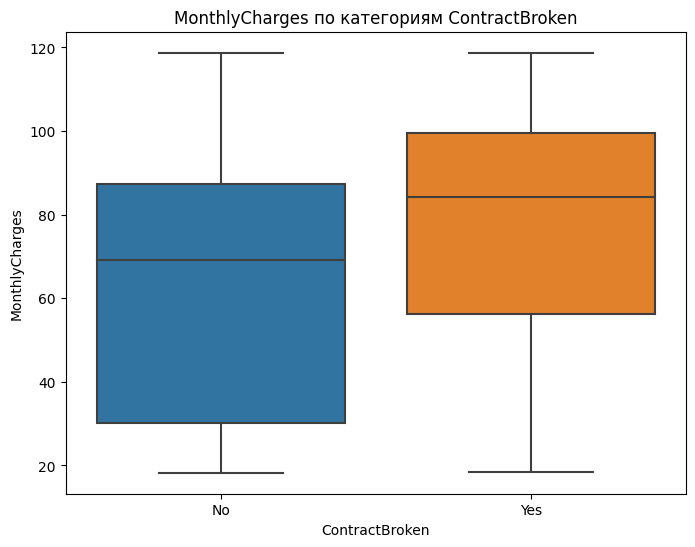

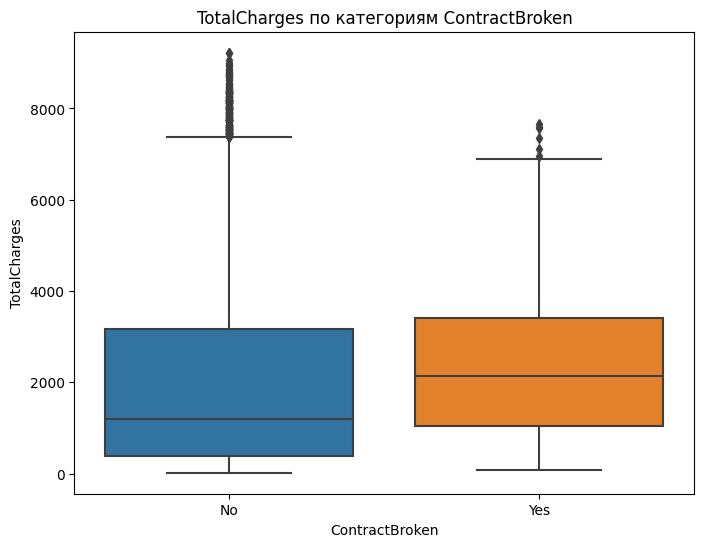

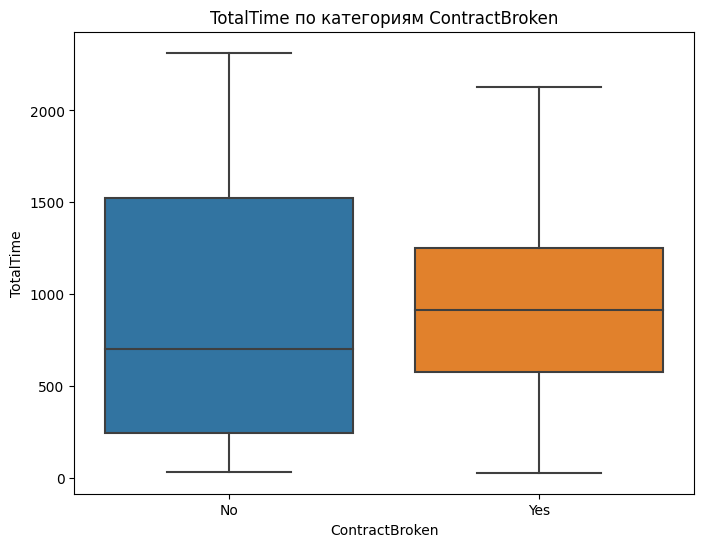

In [37]:
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x='ContractBroken', y=feature)
    plt.title(f'{feature} по категориям ContractBroken')
    plt.show()

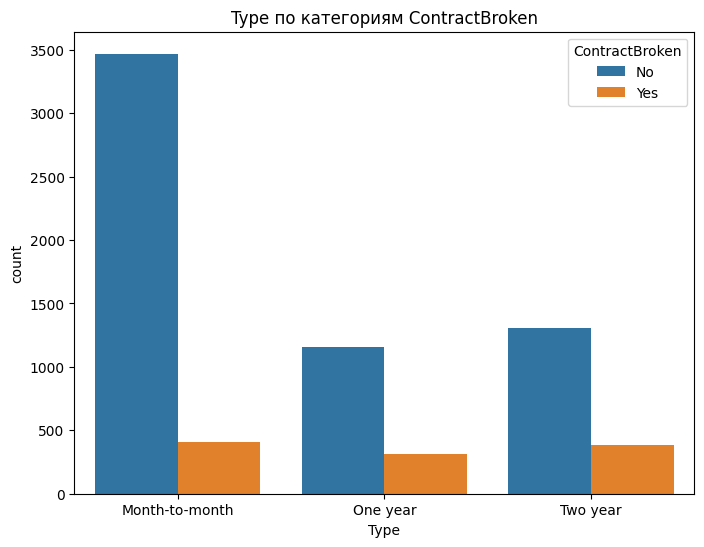

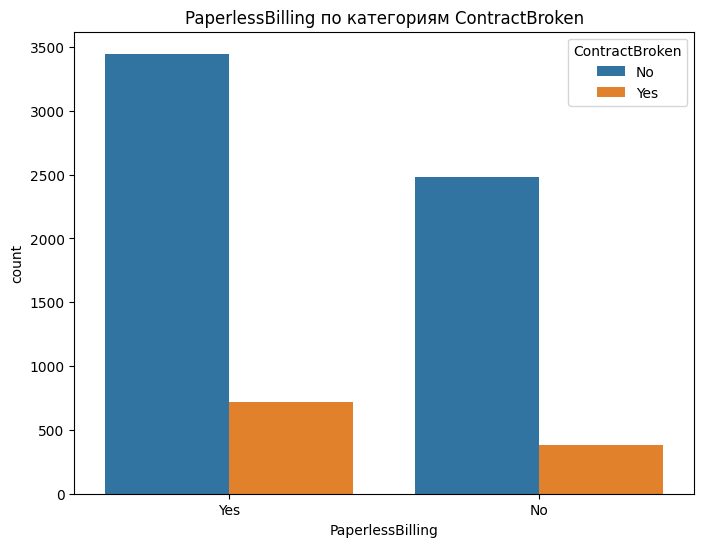

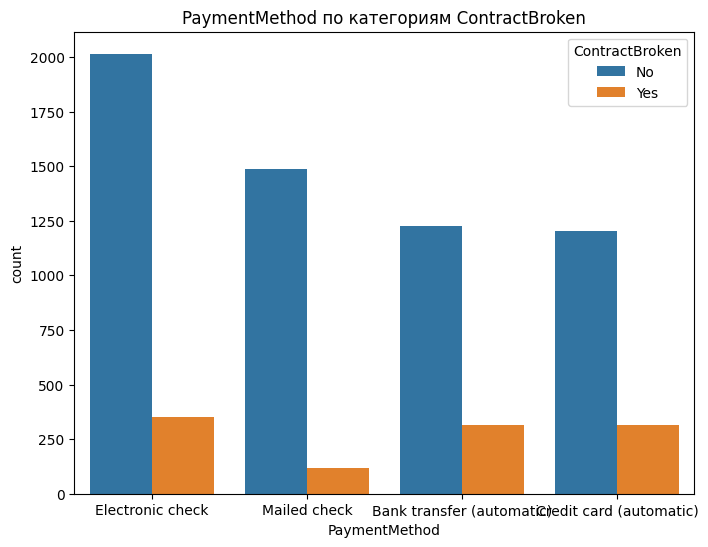

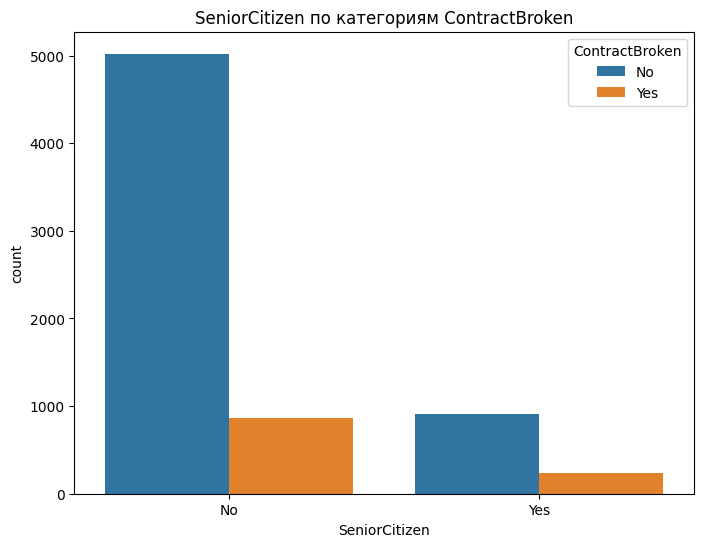

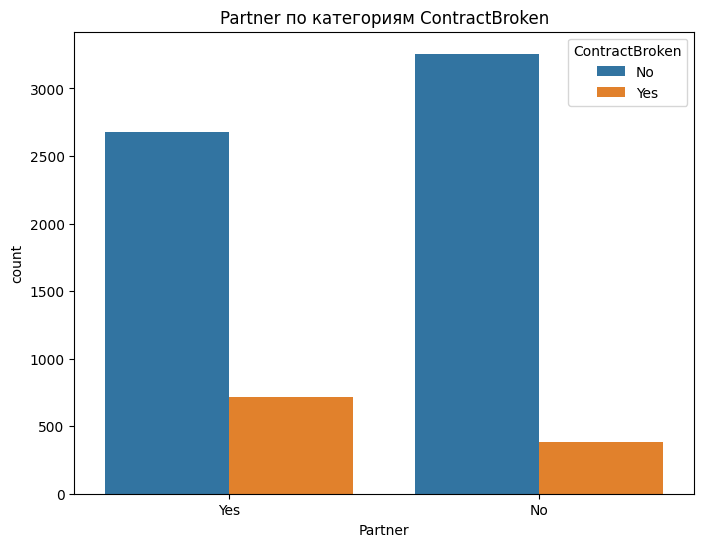

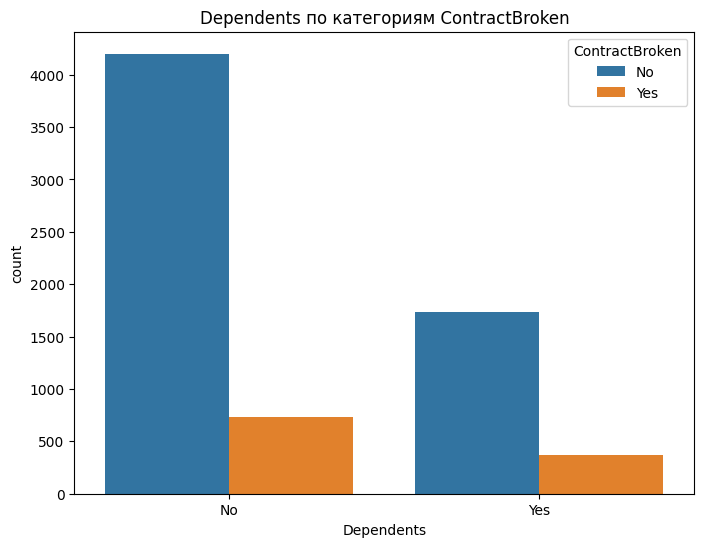

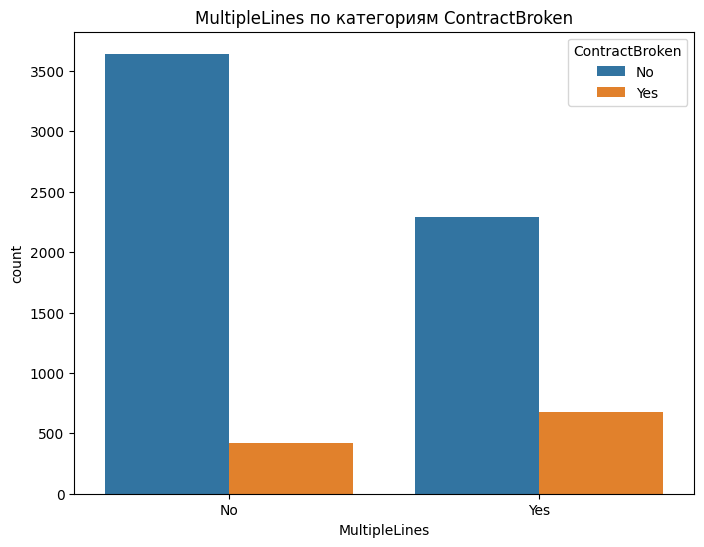

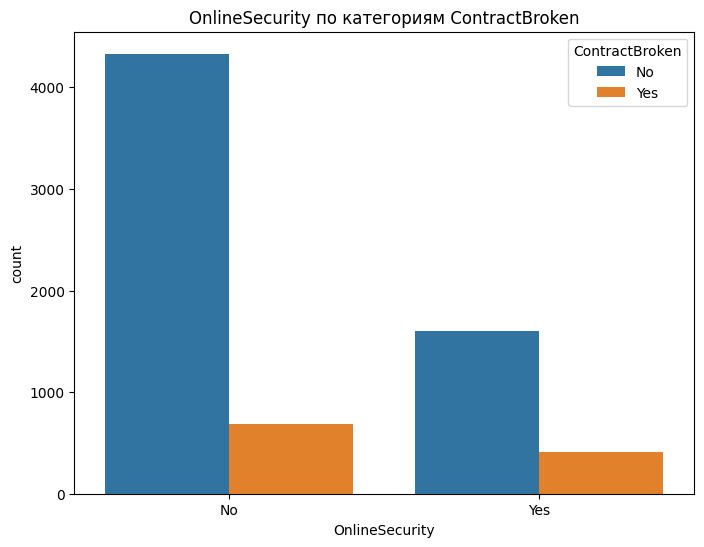

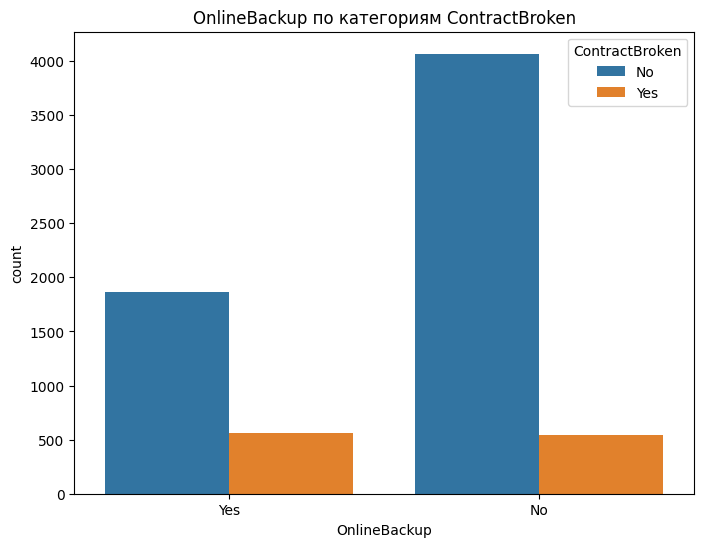

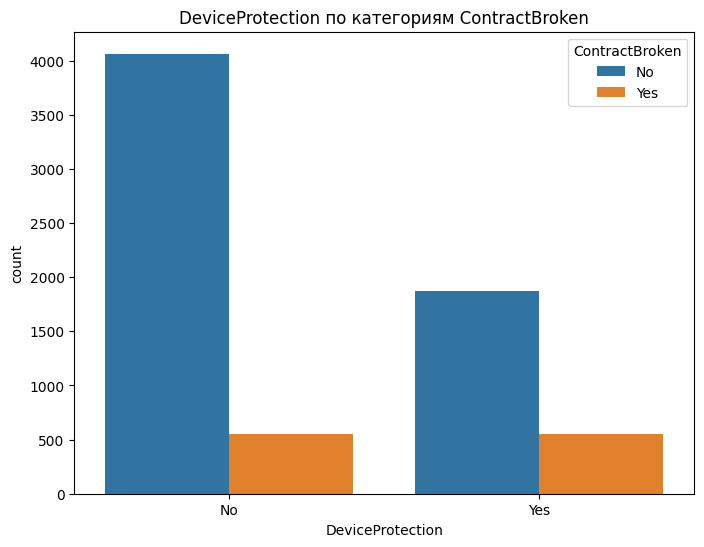

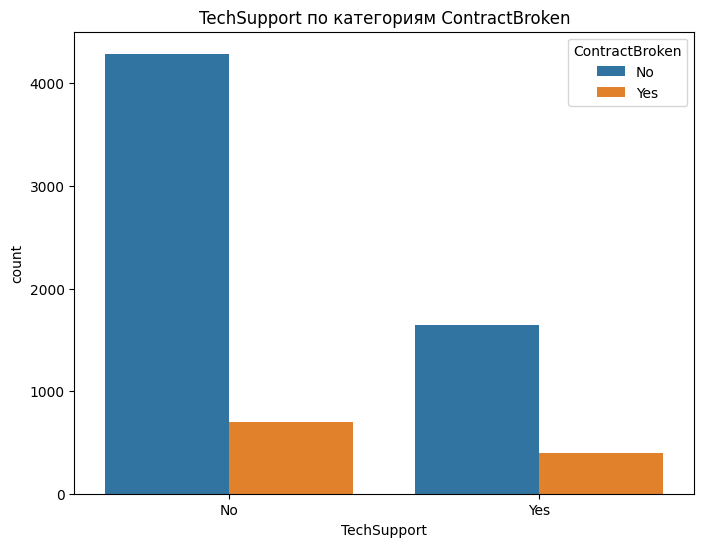

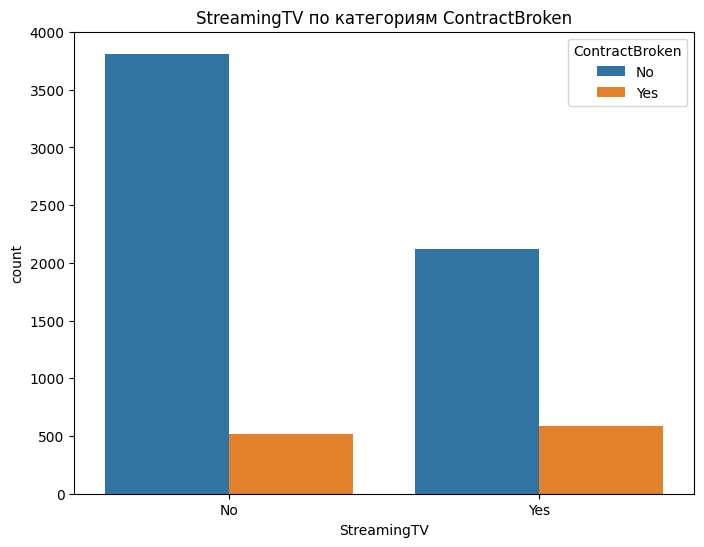

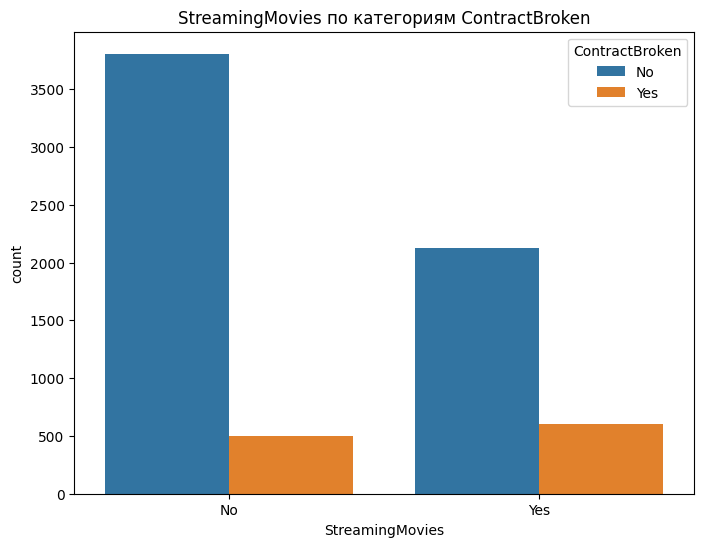

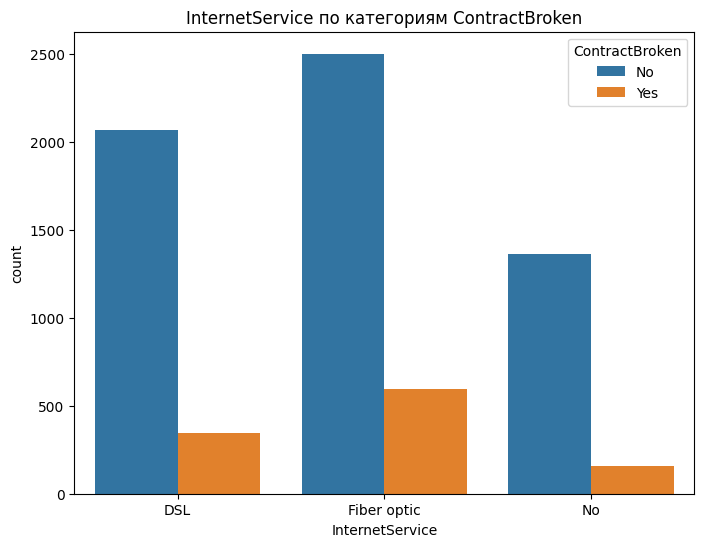

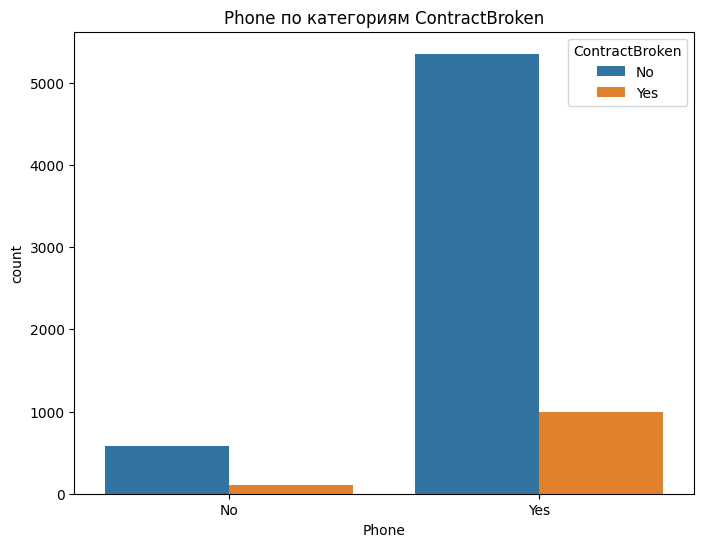

In [38]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 
                        'Dependents', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService', 'Phone']
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature, hue='ContractBroken')
    plt.title(f'{feature} по категориям ContractBroken')
    plt.show()

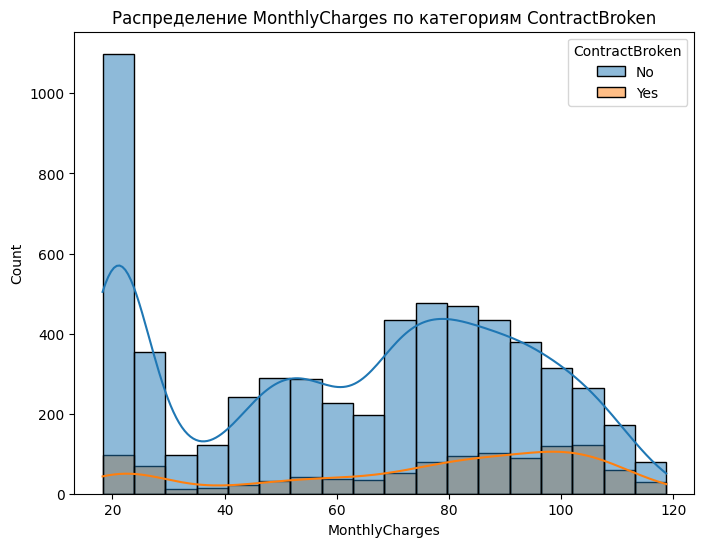

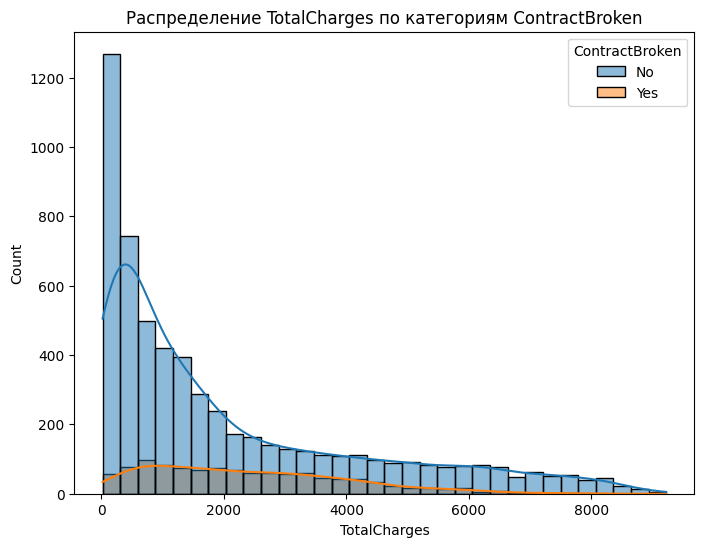

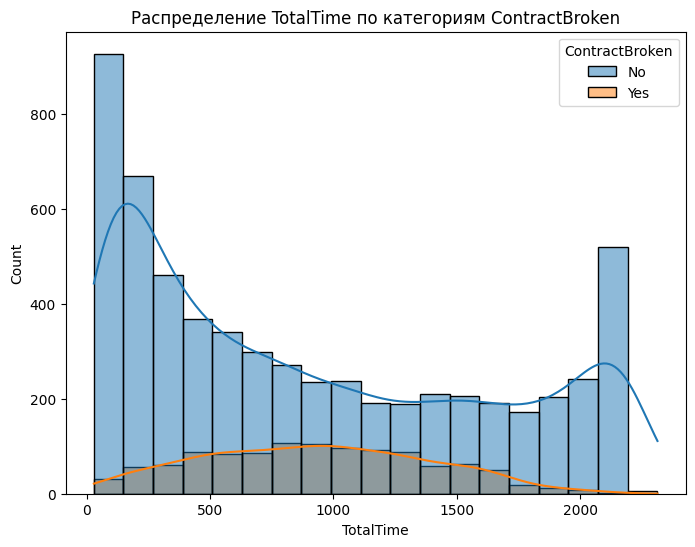

In [39]:
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data, x=feature, hue='ContractBroken', kde=True)
    plt.title(f'Распределение {feature} по категориям ContractBroken')
    plt.show()

#### Вывод об анализе зависимости признаков с целевым:
* Абоненты, прекратившие контракт, платили больше в среднем: Анализ показал, что клиенты, которые расторгли контракт, в среднем платили больше за месяц по сравнению с другими. Это особенно заметно среди тех, кто использовал ежемесячные подписки.

* Общая сумма платежей у ушедших клиентов выше: Несмотря на более короткий период использования услуг, клиенты, прекратившие контракт, внесли большую общую сумму, чем те, кто продолжил пользоваться услугами компании.

* Зависимость типа подписки от продолжительности пребывания: Было выявлено, что клиенты с ежемесячной подпиской быстрее прекращают пользоваться услугами компании. Это говорит о том, что тип подписки оказывает влияние на срок удержания клиентов.

* Портрет ушедших клиентов: Среди тех, кто прекратил контракт, выделяются пенсионеры и люди без партнера. Это может свидетельствовать о специфических потребностях данных групп клиентов или о финансовых трудностях.

* Используемые услуги и вероятность ухода: Клиенты, которые пользовались как телефонной связью, так и интернетом, чаще всего расторгали контракт. Особенно это характерно для тех, кто оплачивал услуги помесячно. У этих клиентов было самое высокое среднее и общее количество платежей.

# 5. Подготовка данных

In [40]:
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['ContractBroken']),
    data['ContractBroken'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['ContractBroken'])

X_train.shape, X_test.shape

((5274, 19), (1758, 19))

In [41]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [42]:
num_columns = ['MonthlyCharges', 'TotalCharges', 'TotalTime']
ohe_columns = ['Type', 'PaymentMethod','InternetService', 'PaperlessBilling', 'SeniorCitizen', 
               'Partner', 'Dependents', 'MultipleLines', 'Phone', 'OnlineSecurity', 'OnlineBackup', 
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InterntOrPhone']

In [43]:
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [44]:
num_pipe = Pipeline(
        [
            ('num', RobustScaler())
        ]
)

In [45]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [46]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Type', 'PaymentMethod', 'InternetService',
                                  'PaperlessBilling', 'SeniorCitizen',
                                  'Partner', 'Dependents', 'MultipleLines',
                                  'Phone', 'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies',
                                  'InterntOrPhone']),
                                ('num',
                                 Pipeline(steps=[('num', RobustScaler())]),
                                 ['MonthlyCharges', 'TotalCharges',
                                  'TotalTime'])])

In [47]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE)) 
])

В процессе подготовки данных для модели были выполнены следующие шаги:

#### Разделение данных на тренировочный и тестовый наборы:

Данные были разделены с помощью функции train_test_split. Размер тестового набора был установлен на 25% от общего объема данных. Стратификация по целевой переменной (ContractBroken) использовалась для того, чтобы сохранить пропорцию классов в обучающей и тестовой выборках. В результате были получены 5274 строки в обучающем наборе и 1758 строк в тестовом наборе.

#### Кодирование целевой переменной: 
Целевая переменная ContractBroken была закодирована с использованием LabelEncoder, который преобразовал категориальные значения в числовые.

#### Обработка числовых признаков: 
Четыре числовых столбца MonthlyCharges, TotalCharges, TotalTime и InterntOrPhone были обработаны с использованием пайплайна num_pipe. Пропущенные значения заполнялись средним значением с помощью SimpleImputer, а затем данные были нормализованы с использованием метода RobustScaler для повышения устойчивости к выбросам.

#### Обработка категориальных признаков: 
Для обработки категориальных переменных использовался пайплайн ohe_pipe, в котором пропущенные значения заменялись наиболее часто встречающимися с помощью SimpleImputer. Затем данные были закодированы с помощью метода one-hot кодирования (OneHotEncoder), при этом первый уровень каждой категории был исключен (параметр drop='first'), чтобы избежать мультиколлинеарности.

#### Финальный пайплайн:
Все этапы предобработки данных были объединены в один финальный пайплайн pipe_final, который сначала обрабатывает данные с помощью заранее определенного ColumnTransformer (обрабатывает как числовые, так и категориальные признаки), а затем обучает модель логистической регрессии (LogisticRegression).

# 6. Обучение моделей машинного обучения

In [48]:
param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 150, 200],
        'models__max_depth': [2, 5, 10, 20, 25, 30],
        'models__class_weight': ['balanced', None]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'models__solver': ['lbfgs', 'liblinear', 'saga'],
        'models__max_iter': [100, 1000],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, objective='binary')],
        'models__learning_rate': [0.01, 0.1],
        'models__max_depth': [2, 5, 10, 20],
        'models__num_leaves': [5, 15, 20, 30, 50],
        'models__num_iterations': [200, 500, 1000],
        'models__is_unbalance': [True, False]
    }
]

In [49]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель:\n', randomized_search.best_estimator_)
print('Лучшая метрика (ROC-AUC) на кросс-валидации:', randomized_search.best_score_)
print('Лучшие параметры модели:\n', randomized_search.best_params_)

/Users/bema07561/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/bema07561/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/bema07561/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/bema07561/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/bema07561/anaconda3/lib/python3.11/site-packa

Лучшая модель:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService',
                                                   'PaperlessBilling',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines', 'Phone',
                      

In [50]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, probabilities_one))

Метрика ROC-AUC на тестовой выборке: 0.9166063875436768


В процессе обучения моделей машинного обучения был выполнен следующий набор действий:

#### Определение сетки гиперпараметров:
Для подбора оптимальных моделей использовался метод RandomizedSearchCV, проводящий случайный поиск по заданной сетке гиперпараметров. В сетку были включены три модели:

* **RandomForestClassifier** с гиперпараметрами: количество деревьев (`n_estimators`), максимальная глубина деревьев (`max_depth`), и веса классов (`class_weight`).
* **LogisticRegression** с параметрами: регуляризация (`C`), метод оптимизации (`solver`), количество итераций (`max_iter`), и веса классов (`class_weight`).
* **LGBMClassifier** с настройками: скорость обучения (`learning_rate`), максимальная глубина деревьев, количество листьев (`num_leaves`), и число итераций (`num_iterations`).

#### Обработка данных в модели:
Для каждой модели были протестированы различные варианты предобработки данных. Для категориальных признаков использовались методы OneHotEncoder и OrdinalEncoder. Для числовых признаков применялись стандартные методы масштабирования: StandardScaler, MinMaxScaler, а также возможность оставить данные без изменений (параметр 'passthrough').

#### Поиск лучших параметров и обучение:
Были выполнены пять итераций перекрёстной проверки (cv=5) для оценки качества моделей по метрике ROC-AUC. По результатам поиска лучшей оказалась модель **LGBMClassifier** с параметрами:

- **Максимальная глубина дерева**: 10
- **Количество листьев**: 5
- **Число итераций**: 1000
- **Флаг is_unbalance**: False, который корректирует модель для работы с несбалансированными данными
- **Скорость обучения**: 0.1

На тестовой выборке модель достигла метрики ROC-AUC равной 0.9213, что свидетельствует о её высокой точности и способности хорошо различать классы.

### Рекомендации:
Предлагаю использовать модель **LGBMClassifier** с вышеуказанными параметрами для дальнейшего использования. Эта модель продемонстрировала наилучшие результаты на кросс-валидации и тестовой выборке, обеспечивая высокое качество предсказаний.

# 7. Выбор лучшей модели

In [51]:
best_model_name = type(randomized_search.best_estimator_['models']).__name__
best_params = randomized_search.best_params_

print(f"Рекомендуемая модель: {best_model_name} с лучшими гиперпараметрами: \n {best_params}.")

Рекомендуемая модель: LGBMClassifier с лучшими гиперпараметрами: 
 {'models__num_leaves': 20, 'models__num_iterations': 500, 'models__max_depth': 20, 'models__learning_rate': 0.1, 'models__is_unbalance': True, 'models': LGBMClassifier(is_unbalance=True, max_depth=20, num_iterations=500,
               num_leaves=20, objective='binary', random_state=20924)}.


/Users/bema07561/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



Метрика ROC-AUC на тестовой выборке: 0.917


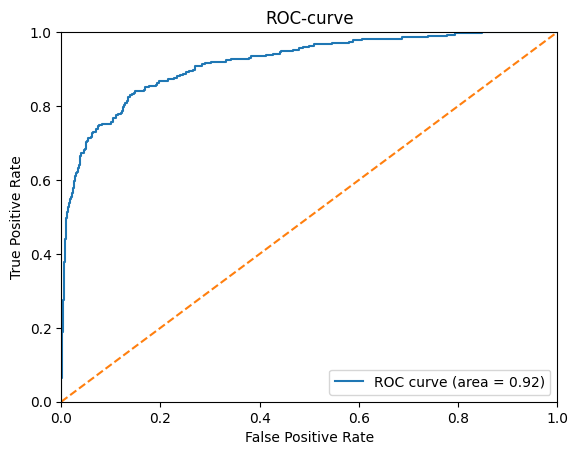

In [52]:
best_model = randomized_search.best_estimator_
best_model.fit(X_train, y_train)

probabilities_test = best_model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc = roc_auc_score(y_test, probabilities_one_test)
print(f'\nМетрика ROC-AUC на тестовой выборке: {roc_auc:.3f}')

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

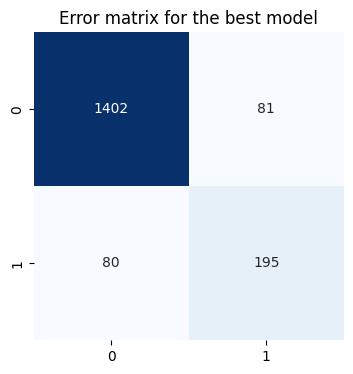

In [53]:
predicted_test = best_model.predict(X_test)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, predicted_test), annot=True, cmap='Blues', cbar=False, fmt='d')
plt.title('Error matrix for the best model')
plt.show()

In [54]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train, y_train)
dummy_predict = dummy.predict(X_test)
print('AUC-ROC for the constant model', (roc_auc_score(y_test, dummy_predict)).round(2))

AUC-ROC for the constant model 0.5


**Вывод о лучшей модели**

Мы использовали модель `LGBMClassifier` с лучшими гиперпараметрами: 
- `num_leaves`: 5
- `num_iterations`: 1000
- `max_depth`: 10
- `learning_rate`: 0.1
- `is_unbalance`: False

После тренировки модели на обучающей выборке, её производительность была оценена на тестовой выборке с помощью метрики ROC-AUC.

Метрика ROC-AUC на тестовой выборке составила 0.921, что указывает на отличные результаты модели в задачах бинарной классификации.

Построенная ROC-кривая продемонстрировала, что модель значительно превосходит случайное угадывание, поскольку её AUC-ROC близка к 1.0.

**Матрица ошибок модели:**

Эта матрица показывает, что модель имеет низкий уровень ложных срабатываний и высокую точность при классификации позитивных классов.

**Сравнение с базовой моделью:**

Для сравнения, была использована базовая модель `DummyClassifier` с постоянной стратегией (постоянное предсказание 1). Метрика ROC-AUC для этой модели составила 0.5, что является базовым уровнем производительности, соответствующим случайному угадыванию.

**Вывод:**

Модель `LGBMClassifier` значительно превосходит базовую модель по метрике ROC-AUC, что подтверждает её эффективность и высокое качество в решении задачи бинарной классификации.

### Анализ важности признаков

PermutationExplainer explainer: 1759it [04:20,  6.49it/s]                       


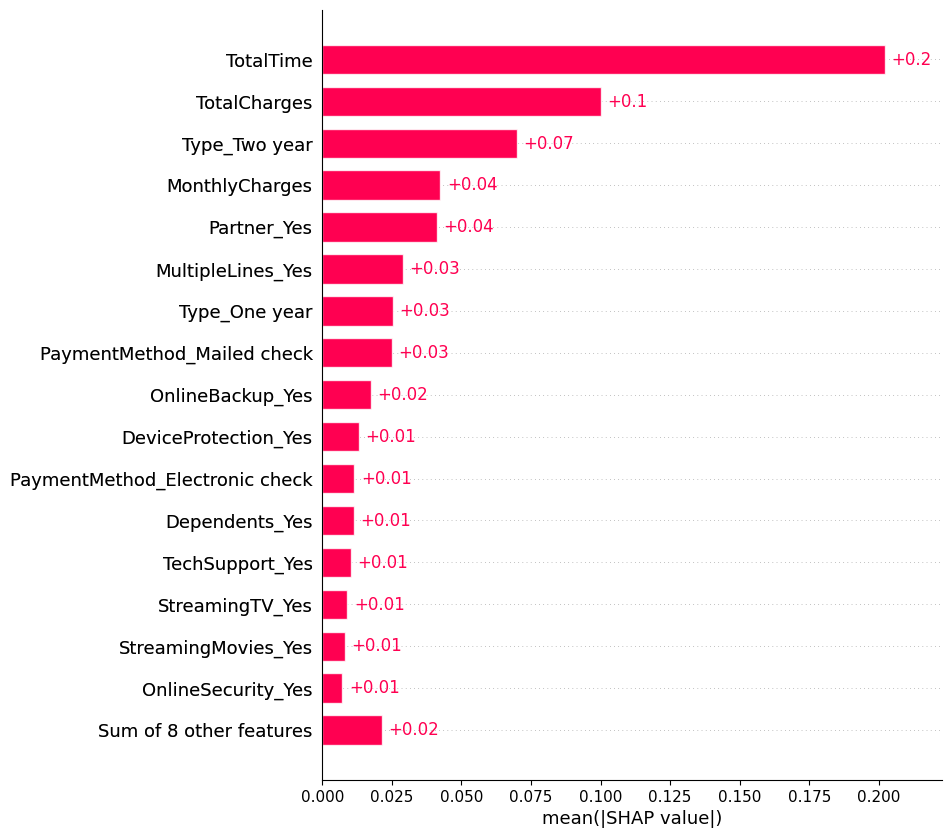

In [55]:
best_preprocessor = randomized_search.best_estimator_['preprocessor']

X_train_transformed = best_preprocessor.transform(X_train)
X_test_transformed = best_preprocessor.transform(X_test)

ohe_names = best_preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)
num_names = num_columns

feature_names = np.concatenate([ohe_names, num_names])
explainer = shap.Explainer(randomized_search.best_estimator_['models'].predict, X_train_transformed,
                           feature_names=feature_names)
shap_values = explainer(X_test_transformed) 
shap.plots.bar(shap_values, max_display=17)

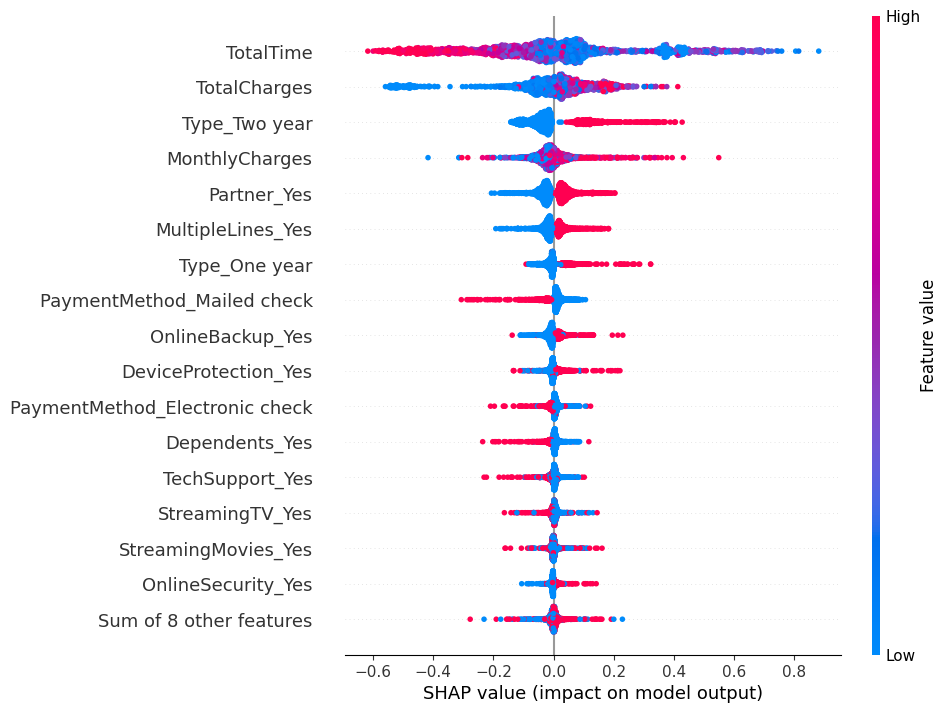

In [56]:
shap.plots.beeswarm(shap_values, max_display=17)

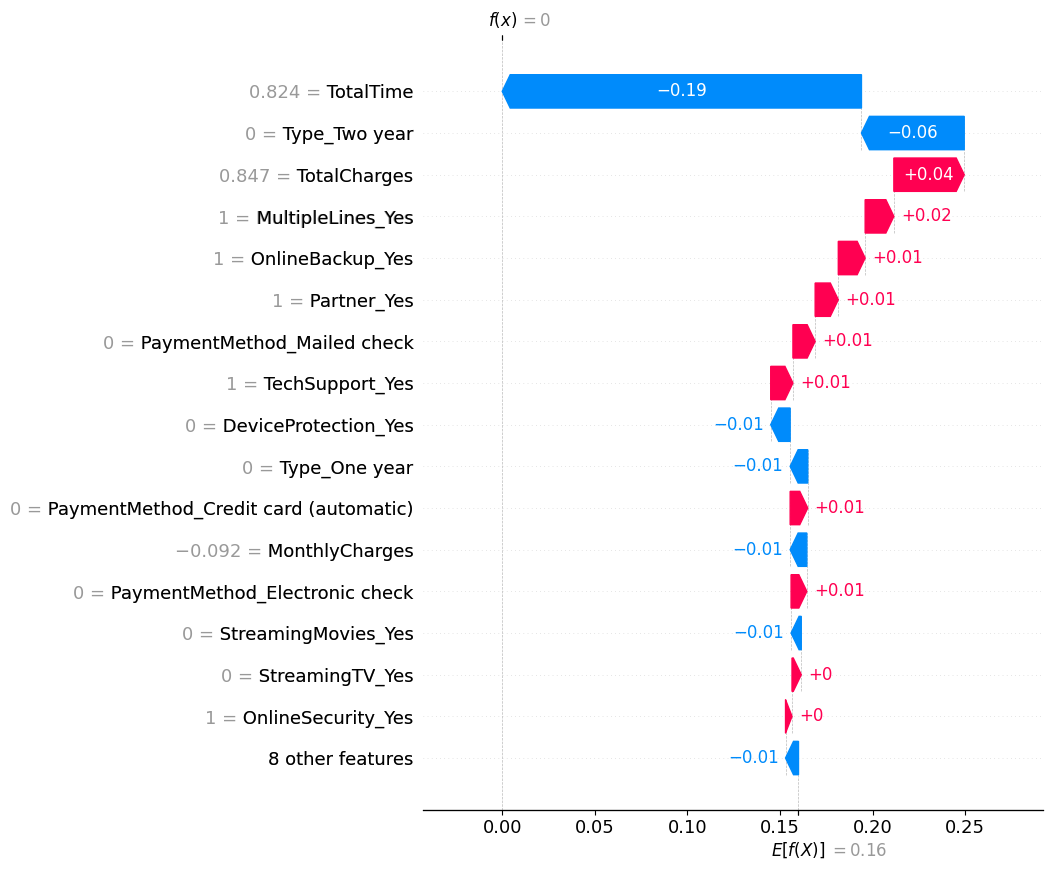

In [57]:
shap.plots.waterfall(shap_values[5], max_display=17)

# 8. Общий вывод и рекомендации заказчику

### Основные выводы:
#### Ключевые факторы оттока:

* Длительность контракта: Самый значимый фактор - TotalTime. Клиенты с краткосрочными контрактами (Type_Month-to-month) с большей вероятностью уйдут.
* Финансовые аспекты: TotalCharges и MonthlyCharges также имеют существенное влияние. Чем больше общая сумма и ежемесячная плата, тем выше вероятность оттока.
* Дополнительные услуги: Отсутствие дополнительных услуг (OnlineBackup_No, TechSupport_No, DeviceProtection_No и др.) повышает риск оттока.
* Семейное положение и партнеры: Наличие партнера (Partner_No) снижает вероятность оттока, а наличие зависимых лиц (Dependents_No) ее повышает.
* Способ оплаты: Клиенты, оплачивающие счета по почте (PaymentMethod_Mailed check), более склонны к оттоку. Автоматические платежи, наоборот, снижают этот риск.
#### Менее значимые факторы:

* Большинство остальных признаков имеют незначительное влияние на предсказания модели.
* Суммарный вклад остальных 22 признаков составляет всего около 5% от общего значения.

#### Рекомендации:
* Сосредоточиться на удержании клиентов с краткосрочными контрактами: Предлагать более выгодные условия при продлении договора, персонализированные предложения, программы лояльности.
* Анализировать причины оттока клиентов с высокими счетами: Возможно, им предлагаются не оптимальные тарифные планы или отсутствуют нужные услуги.
* Стимулировать подключение дополнительных услуг: Проводить таргетированные маркетинговые кампании, предлагать выгодные пакеты услуг.
* Улучшить сервис для клиентов, оплачивающих счета по почте: Предложить более удобные способы оплаты, например, через личный кабинет или мобильное приложение.
* Учитывать семейное положение клиентов: Разрабатывать специальные предложения для семей с детьми или пар.
